# Ensemble models

In this chapter we learn about ensemble modeling, which is a technique for training multiple ML algorithms (referred to as `base learners`) and combining their learning into one. Two very common ways of doing this are **bagging** and **boosting**.

## Reading and processing data

Let begin by reading our data. In this case, our data is already split into training and testing. How convenient!

In [1]:
import pandas as pd

df_train = pd.read_csv("data/adult_train.csv", sep = ",", header = 0)
df_test = pd.read_csv("data/adult_test.csv", sep = ",", skiprows = 2, names = df_train.columns)
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Let's check our column types:

In [2]:
df_train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

Let's create a list of our categorical columns. Here keep every column whose data types is `object`, but we may need to narrow the list down even further.

In [3]:
cat_vars = df_train.select_dtypes('object').columns.to_list()
cat_vars.pop() # removes `income` from cat_vars
cat_vars

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

All of these columns look like they would be good candidates type `category`, but we covered that in a previous notebook and no need to return to that. We will take them as-is.

Let's drop any rows with missing data from the training and test sets. This is a very conservative approach and if we don't have a lot of data to begin with we may want to try a different approach such as imputing the missing values.

In [4]:
df_train = df_train.dropna(axis = 0)
df_test = df_test.dropna(axis = 0)

We now split the data into features and labels.

In [5]:
X_train = df_train.drop(columns = 'income')
Y_train = df_train['income']

X_test = df_test.drop(columns = 'income')
Y_test = df_test['income']

As part of data pre-processing, we need to one-hot-encode the categorical features. We already learned how to use `OneHotEncoder` in `sklearn.preprocessing`, but we will use another `OneHotEncoder` this time in the `category_encoders` library. It's important to know that `sklearn` is not the only library for ML in Python, so this will give us a change to try a new one. You should not be surprised to find out that the two have a lot in common, but also some slight additions that make things easier for us.

Before applying it to the data, let's create a very small train and test data with two rows and two columns and intentiall modify them slightly, just to learn how `OneHotEncoder` works.

In [6]:
import numpy as np

X_small_train = X_train.loc[2:3, ["race", "sex"]]
X_small_train.iloc[1, 1] = np.nan # introduce a nan to see what happens
X_small_train.head()

,race,sex
2,White,Male
3,Black,NaN


In [7]:
X_small_test = X_train.loc[4:5, ["race", "sex"]]
X_small_test.head()

,race,sex
4,Black,Female
5,White,Female


The `OneHotEncoder` class has two very important arguments called `handle_missing` and `handle_unknown` ethier of which can be set to `"error"`, `"return_nan"`, `"value"` or `"indicator"`.

In [9]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 1.9 MB/s eta 0:00:011


In [50]:
import category_encoders as ce

handle = 'return_nan' # options are: 'error', 'return_nan', 'value', and 'indicator'
onehoter =  ce.OneHotEncoder(return_df = True, 
                             cols = ["race", "sex"], 
                             drop_invariant = True,
                             use_cat_names = True, 
                             handle_missing = handle, 
                             handle_unknown = handle)

### Exercise

Let's examing the following settings and describe what happens when you run `onehoter.fit` on `X_small_train` and then run `onehoter.transform` on `X_small_train` and `X_small_test`.

- Set `handle = "indicator"` and `drop_invariant = False`.
- Set `handle = "error"`.
- Set `handle = "value"` and `drop_invariant = True`.
- Set `handle = "value"` and `drop_invariant = False`.
- Set `handle = "return_nan"` and `drop_invariant = True`.
- Set `handle = "return_nan"` and `drop_invariant = False`.

Which settings do you think are better in production? Why?

In [51]:
X_small_train.head()

,race,sex
2,White,Male
3,Black,NaN


In [52]:
onehoter.fit_transform(X_small_train)

,race_ White,race_ Black,sex_ Male,sex_nan
2,1.0,0.0,1.0,0.0
3,0.0,1.0,NaN,NaN


In [53]:
X_small_test.head()

,race,sex
4,Black,Female
5,White,Female


In [54]:
onehoter.fit_transform(X_small_test)

,race_ Black,race_ White,race_nan
4,1.0,0.0,0.0
5,0.0,1.0,0.0


### End of exercise

Let's now run `OneHotEncoder` on the data. We create an instance of the class, which we call `onehoter`.

In [55]:
import category_encoders as ce

handle = "value" # options are: 'error', 'return_nan', 'value', and 'indicator'
onehoter =  ce.OneHotEncoder(return_df = True, 
                             cols = cat_vars, 
                             drop_invariant = False,
                             use_cat_names = True, 
                             handle_missing = handle, 
                             handle_unknown = handle)

Now we appy `onehoter` it to the training and test data.

In [56]:
onehoter.fit(X_train)
X_train_encoded = onehoter.transform(X_train)
X_test_encoded = onehoter.transform(X_test)

In [57]:
print("X_train shape = {}".format(X_train.shape))
print("X_train_encoded shape = {}".format(X_train_encoded.shape))

print("X_test shape = {}".format(X_test.shape))
print("X_test_encoded shape = {}".format(X_test_encoded.shape))

X_train shape = (32561, 14)
X_train_encoded shape = (32561, 108)
X_test shape = (16281, 14)
X_test_encoded shape = (16281, 108)


It might be a good idea to ensure that the training and test sets have the same number of columns before proceeding to the next step. This is one way to ensure that we have consistency between the two. We can use `assert` to do it.

In [58]:
assert(X_train_encoded.shape[1] == X_test_encoded.shape[1])

We're now ready to train models on the one-hot-encoded data. Let's start with a random forest model. Notice that the `RandomForestClassifier` class below has several hyper-parameters such as `n_estimators`, `max_features`, `max_depth` and `min_leaf_size`. The latter two were inherited from the decision tree. For reasons that will become apparent later, we store these hyper-parameters in a dictionary called `hypers` and then pass them to the classifier. When we have a dictionary whose keys match a fuction's argument names, there is a neat functionality in Python that allows us to pass the dictionary to the function using `**` followed by the name of the dictionary. This saves us from having to type the argument names twice: once in the dictionary and once when calling the function.

## Training a random forest classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier

hypers = {"n_estimators": 100, "max_features": "sqrt", "max_depth": 20, "min_samples_leaf": 10}
clf_rf = RandomForestClassifier(random_state = 0, verbose = True, **hypers)

Let's now train the random forest classifier.

In [60]:
clf_rf.fit(X_train_encoded, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0,
                       verbose=True, warm_start=False)

If you see a message about using a sequential backend, it's because a random forest is an algorithm that can easily run in parallel by just training many trees concurrently. Since we don't have a large data set we don't need to bother with that here, but it's useful to know about this in case we need to speed up the training job.

One by product of tree-based models is that they provide us with a list showing the relative importance of each feature to the model. So even if we're not interested in the trained model the random forest returns, we can still use it for **feature selection**: namely train the random forest on the whole data to get the top $n$ most important features and later pass only those features to another algorithm we wish to use to train a model. Note that because we one-hot-encoded the data, a feature here is not just one of the categorical columns, but each category of each categorical column is its own feature. We can find the feature importance values in `clf_rf.feature_importances_`.

In [61]:
len(clf_rf.feature_importances_)

108

Let's store the feature importance values in a `DataFrame` and use `seaborn` to visualize the top 10.

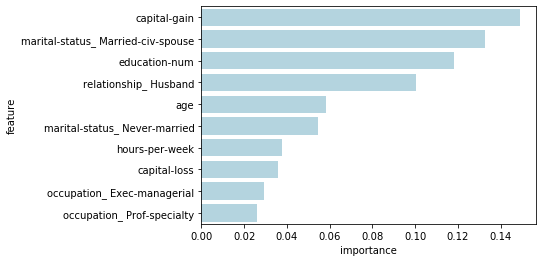

In [62]:
df_var_imp = pd.DataFrame({"feature": X_train_encoded.columns, 
                           "importance": clf_rf.feature_importances_})
df_var_imp.sort_values(by = "importance", ascending = False, inplace = True)

import seaborn as sns
ax = sns.barplot(x = "importance", y = "feature", data = df_var_imp.head(10), color = "lightblue")

To get predictions from the trained model, we simply call the `predict` method and pass it the data. To check if we're overfitting or not, we can get predictions for both the training and the test data. Once we have the predictions, we can call the `accuracy_score` function to get the accuracy on the training and test data, assuming that accuracy is a good metric to use here.

We're already written the code there for you. But there's a problem with it. Your job is to run it and see if you can debug it.

In [63]:
Y_hat_train = clf_rf.predict(X_train_encoded)
Y_hat_test = clf_rf.predict(X_test_encoded)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [64]:
Y_train.head()

0     <=50K
1     <=50K
2     <=50K
3     <=50K
4     <=50K
Name: income, dtype: object

In [65]:
Y_test.head()

0     <=50K.
1     <=50K.
2      >50K.
3      >50K.
4     <=50K.
Name: income, dtype: object

There is a slight discrepancy between the labels as they show up in the training data and the test data: the labels in the test data end with a period. So we need to remove the period when we evaluate the model. We do so using `.str.replace("\\.$", "")` in the cell below, where `"\\.$"` is a regular expression that searches for a period at the end of a string.

In [66]:
from sklearn.metrics import accuracy_score
acc_train = accuracy_score(Y_train, Y_hat_train)
acc_test = accuracy_score(Y_test.str.replace("\\.$", ""), Y_hat_test)

We will be storing some important results in a table we call `results`. If this table doesn't exist (first time we run it) it will initialized by the code below.

In [67]:
try:
    results # checks if this object exists or not
except NameError:
    results = pd.DataFrame(columns = ["algo", "acc_train", "acc_test"]) # initiates it

Every row of the table will store accuracy metrics for one training iteration given one set of hyper-parameters (also listed in the table).

In [68]:
model_name = str(clf_rf.__class__).split('.')[-1].strip("\"\'>")
results.loc[len(results), 0:3] = [model_name, acc_train, acc_test]

for hp in hypers.keys():
    results.loc[len(results) - 1, hp] = hypers[hp]

In [69]:
results

,algo,acc_train,acc_test,n_estimators,max_features,max_depth,min_samples_leaf
0,RandomForestClassifier,0.865852,0.861126,100.0,sqrt,20.0,10.0


We can now go back up to where we trained the random forest classifier and change its hyper-parameters, retrain it, re-evaluate it, and finally store the results as a new row in the `results` table. This way we can compare our different runs. But to avoid navigating up and down the notebook, we're going to make things even easier: Let's take the code that needs to rerun every time we change the hyper-parameters and dump it in a python file called `train_evaluate.py`. We can use the `%%writefile` magic to do this from a cell, as shown here:

In [70]:
%%writefile train_evaluate.py
model.fit(X_train_encoded, Y_train)

Y_hat_train = model.predict(X_train_encoded)
Y_hat_test = model.predict(X_test_encoded)

acc_train = accuracy_score(Y_train, Y_hat_train)
acc_test = accuracy_score(Y_test.str.replace("\\.$", ""), Y_hat_test)

try:
    results # checks if this object exists or not
except NameError:
    results = pd.DataFrame(columns = ["algo", "acc_train", "acc_test"]) # initiates it

model_name = str(model.__class__).split('.')[-1].strip("\"\'>")
results.loc[len(results), 0:3] = [model_name, acc_train, acc_test]

for hp in hypers.keys():
    results.loc[len(results) - 1, hp] = hypers[hp]

Writing train_evaluate.py


Now here's all we have to do: In the next cell we're going to change the hyper-parameters to whatever we want to try next. We can even add new hyper-parameters to `hypers`.

In [74]:
hypers = {"n_estimators": 200, "max_features": "sqrt", "max_depth": 5, "min_samples_leaf": 10}
model = RandomForestClassifier(random_state = 0, **hypers)

We then run the `train_evaluate.py` script using the new hyper-parameters values. We can run an external Python script from inside the notebook using the `%run` magic. It is important to use the `-i` switch (stands for interactive), which runs the script using the **same** Python session that the notebook is hosting. Without the `-i` switch, the script would run in a new Python session and would not be aware of the variables we are providing above.

In [75]:
%run -i train_evaluate.py

Every time we do a new run, a new row will be added to `results`, and we can compare it to all the runs so far.

In [76]:
results

,algo,acc_train,acc_test,n_estimators,max_features,max_depth,min_samples_leaf
0,RandomForestClassifier,0.865852,0.861126,100.0,sqrt,20.0,10.0
1,RandomForestClassifier,0.865698,0.861679,200.0,sqrt,20.0,10.0
2,RandomForestClassifier,0.838856,0.838093,200.0,sqrt,5.0,10.0


## Training a gradient boosted classifier

Let's now train a gradient boosted classifier. Shrinkage is controlled by `learning_rate`.

In [77]:
from sklearn.ensemble import GradientBoostingClassifier

hypers = {"n_estimators": 100, "max_features": "sqrt", "max_depth": 20, "min_samples_leaf": 10, "learning_rate": 0.5}
clf_gb = GradientBoostingClassifier(loss = 'deviance', verbose = True, **hypers)

One again we train the classifier by calling `fit`.

In [78]:
clf_gb.fit(X_train_encoded, Y_train)

      Iter       Train Loss   Remaining Time 
         1           0.7669            6.27s
         2           0.6581            6.86s
         3           0.5942            7.24s
         4           0.5572            6.92s
         5           0.5275            6.80s
         6           0.5078            6.61s
         7           0.4863            6.56s
         8           0.4704            6.32s
         9           0.4541            6.25s
        10           0.4461            5.99s
        20           0.3658            5.03s
        30           0.3004            4.41s
        40           0.2615            3.76s
        50           0.2252            3.14s
        60           0.4636            2.51s
        70  4149380818.5624            1.89s
        80  4149408361.5125            1.24s
        90 2529277821008990.0000            0.62s
       100 25600531157725773849033008733193130127945220218109646575908760941004906520544694648296953229155433121915727406392372234992654221

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=20,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=True,
                           warm_start=False)

We can display the variable importance plot for a gradient boosted classifier as well. The results should not look very different from using random forests.

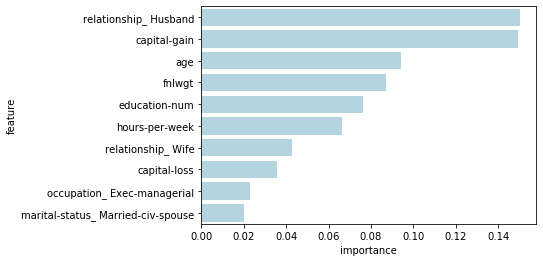

In [79]:
df_var_imp = pd.DataFrame({"feature": X_train_encoded.columns, 
                           "importance": clf_gb.feature_importances_})
df_var_imp.sort_values(by = "importance", ascending = False, inplace = True)

import seaborn as sns
ax = sns.barplot(x = "importance", y = "feature", data = df_var_imp.head(10), color = "lightblue")

We now score the training and test sets with the trained model from the previous step.

In [80]:
Y_hat_train = clf_gb.predict(X_train_encoded)
Y_hat_test = clf_gb.predict(X_test_encoded)

We obtain the accuracy scores in either case.

In [81]:
acc_train = accuracy_score(Y_train, Y_hat_train)
acc_test = accuracy_score(Y_test.str.replace("\\.$", ""), Y_hat_test)

And we store the results in the same `results` table as bofere.

In [82]:
model_name = str(clf_gb.__class__).split('.')[-1].strip("\"\'>")
results.loc[len(results), 0:3] = [model_name, acc_train, acc_test]

for hp in hypers.keys():
    results.loc[len(results) - 1, hp] = hypers[hp]

In [83]:
results

,algo,acc_train,acc_test,n_estimators,max_features,max_depth,min_samples_leaf,learning_rate
0,RandomForestClassifier,0.865852,0.861126,100.0,sqrt,20.0,10.0,NaN
1,RandomForestClassifier,0.865698,0.861679,200.0,sqrt,20.0,10.0,NaN
2,RandomForestClassifier,0.838856,0.838093,200.0,sqrt,5.0,10.0,NaN
3,GradientBoostingClassifier,0.955929,0.823537,100.0,sqrt,20.0,10.0,0.5


In [105]:
hypers = {"n_estimators": 100, "max_features": "sqrt", "max_depth": 3, "min_samples_leaf": 10, "learning_rate": 0.8}
model = GradientBoostingClassifier(loss = 'deviance', **hypers)

We then run the `train_evaluate.py` script using the new hyper-parameters values. We can run an external Python script from inside the notebook using the `%run` magic. It is important to use the `-i` switch (stands for interactive), which runs the script using the **same** Python session that the notebook is hosting. Without the `-i` switch, the script would run in a new Python session and would not be aware of the variables we are providing above.

In [106]:
%run -i train_evaluate.py

In [107]:
results

,algo,acc_train,acc_test,n_estimators,max_features,max_depth,min_samples_leaf,learning_rate
0,RandomForestClassifier,0.865852,0.861126,100.0,sqrt,20.0,10.0,NaN
1,RandomForestClassifier,0.865698,0.861679,200.0,sqrt,20.0,10.0,NaN
2,RandomForestClassifier,0.838856,0.838093,200.0,sqrt,5.0,10.0,NaN
3,GradientBoostingClassifier,0.955929,0.823537,100.0,sqrt,20.0,10.0,0.5
4,GradientBoostingClassifier,0.98231,0.851852,100.0,sqrt,20.0,10.0,0.4
5,GradientBoostingClassifier,0.88434,0.867207,100.0,sqrt,5.0,10.0,0.4
6,GradientBoostingClassifier,0.922822,0.864566,100.0,sqrt,10.0,10.0,0.4
7,GradientBoostingClassifier,0.93956,0.854616,100.0,sqrt,10.0,10.0,0.7
8,GradientBoostingClassifier,0.936642,0.854677,100.0,sqrt,10.0,10.0,0.6
9,GradientBoostingClassifier,0.898068,0.863092,100.0,sqrt,6.0,10.0,0.6


### Exercise

Return to the two classifiers we trained above and change the hyper-parametrs and train at least 10 different random forest and 10 different gradient boosted classfiers. Make sure to store all the training runs in the `results` table. Once you have all the runs, find the best model you have and report its accuracy and state your choice of hyper-parametrs. We will compare this with everyone else in class to see who got the best model.

Before you begin, recall that bagged learners like random forests reduce variance, so we want their **base-learner** to be more likely overfit (**high variance**). On the other hand, boosted learners like gradient boosted trees reduce bias, so we want their **base-learners** to be more likely to underfit (**high bias**). So your choice of hyper-parameters for the base-learners (decision trees) in each case should reflect this tendency.

To make it easy, we're already pasted the cells for you here. Run the next two cells 10 times (after changing `hypers` every time) and you will train 10 different **random forests**.

In [ ]:

def dtree_grid_search(X,y,nfolds, criteria):
    param_grid = { 'max_depth': np.arange(3, 15), 'min_samples_leaf':np.arange(2, 6)}
    # decision tree model
    
    dtree_model=DecisionTreeClassifier(criterion=criteria)
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    
    return dtree_gscv.best_params_

def report_best(X, y, X_tst, y_tst, nfolds, criteria, lbls):    
    best_params = dtree_grid_search(X, y, nfolds, criteria)
    print(f'Best Params: {best_params}')
    classifier = DecisionTreeClassifier(criterion=criteria, 
                                               max_depth=best_params['max_depth'], 
                                               min_samples_leaf=best_params['min_samples_leaf'])
    classifier.fit(X_train, y_train)
    y_ent_pred = classifier.predict(X_tst)
    print("Entropy accuracy is : {}%".format(accuracy_score(y_tst, y_ent_pred)*100))
    print(classification_report(y_tst, y_ent_pred, target_names=lbls))

In [113]:
from sklearn.model_selection import GridSearchCV
import numpy as np

hypers = {"n_estimators": [100], "max_features": ["sqrt", "log2"], "max_depth": np.arange(3,10), "min_samples_leaf": np.arange(4,10)}
model = RandomForestClassifier(random_state = 0, n_jobs = -1)
dtree_gscv = GridSearchCV(model, hypers, cv=5)
dtree_gscv.fit(X_train_encoded, Y_train)

print(dtree_gscv.best_params_)

{'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'n_estimators': 100}


In [ ]:

hypers = {"n_estimators": 200, "max_features": "sqrt", "max_depth": 20, "min_samples_leaf": 10}
model = RandomForestClassifier(random_state = 0, **hypers)

In [ ]:
%run -i train_evaluate.py

Run the next two cells 10 times (after changing `hypers` every time) and you will train 10 different **gradient boosted trees**.

In [ ]:
hypers = {"n_estimators": 100, "max_features": "sqrt", "max_depth": 20, "min_samples_leaf": 10, "learning_rate": 0.5}
model = GradientBoostingClassifier(loss = 'deviance', **hypers)

In [ ]:
%run -i train_evaluate.py

When you're done with your runs, you can check all the results by running the next cell.

In [ ]:
results

Make sure that you check the classifier's documentation and understand what `n_estimators`, `max_features`, `max_depth`, and `min_leaf_size` represent. Then, answer the following question:

- What seems to be the effect of changing each of these hyper-parameters on the accuracy of the training and test data?
- Does this match your intuition about how these hyper-parameters work?
- Are there any hyper-parameters that seem promising and worth trying to tune?

### End of exercise

Hyper-parameter tuning can be a very time-consuming and difficult task. In a future lecture, we will see how we can use a Python library to automatically specify different hyper-parameter values ahead of time and train different models. This will save us from having to manually re-run external scripts or collect results, but for now this will suffice and it's also a chance to show-case some more advanced Python and Jupyter functionality.

## Training a non-tree-based ensemble model

We finish this notebook by providing an example of a non-tree-based classifier. Tree-based classifiers are so common that they have their own functions in `sklearn`, but if we want we can choose any base-learners and pass it to the `BaggingClassifier` or any of the other ensemble learners in `sklearn.ensemble`. In the following example, we use `KNeighborsClassifier` as the base learner and train a bagged classifier.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

bag_cls = BaggingClassifier(KNeighborsClassifier(), max_samples = 0.5, max_features = 0.5)
bag_cls.fit(X_train_encoded, Y_train)

We can let the classifier predict on the training and test data.

In [ ]:
Y_hat_train = bag_cls.predict(X_train_encoded)
Y_hat_test = bag_cls.predict(X_test_encoded)

And obtain just as before.

In [ ]:
acc_train = accuracy_score(Y_train, Y_hat_train)
acc_test = accuracy_score(Y_test.str.replace("\\.$", ""), Y_hat_test)

print("Accuracy on training data = {:.02} and on test data = {:.02}".format(acc_train, acc_test))

So ensemble classifiers are a great method to improve accuracy if we're willing to pay the computational cost. Another downside as we saw in this notebook is that we add new hyper-parameters on top of the ones we inherit from the base learner and hyper-parameter tuning becomes a daunting task. In fact, one of the short-comings in this notebook is that we did our hyper-parameter tuning on the **test data** when we should have used a **validation data** instead. If we try a few different runs we can get away with this, but if we get serious about hyper-parameter tuning then as we learned the right way to do it is to evaluate the hyper-parameters on the **validation data** (or to use cross-validation) and leave the **test data** to evaluate the accuracy of the **final model** at the end.